# Trying Bayes Factors on Paper I (Shapovalova+16)

In this notebook, we implement the Bayes factor calculation from the Dynamic Nested Sampling results produced for two *dynesty* runs.

In [1]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import pandas as pd

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
import scienceplots

plt.style.use(['science', 'grid', 'high-vis'])

# seed the random number generator
rstate = np.random.default_rng(113)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 15})
rcParams.update({'figure.dpi': 300})

In [3]:
import dynesty
import GPy
import celerite
from celerite import terms
from eztao.ts import neg_param_ll, sample_carma, carma_fit, dho_fit
from eztao.carma import CARMA_term, DHO_term, DRW_term
from scipy.optimize import minimize


plt.rc('axes', unicode_minus=False)

We first obtain the complete Table 1 data of Shapovalova et. al (which we dub as Paper I) from [Vizier](https://cdsarc.cds.unistra.fr/viz-bin/cat/J/ApJS/222/25#/browse). This Table provides the light curves of E1821+643 as measured on the Johnson-Cousins R, V, and B bands, together with the seeing conditions per observation.

In [4]:
E1821 = pd.read_csv('Shap+16.txt', sep='|', index_col=0)
E1821

,Date,JD,seeing,Rmag,e_Rmag,Vmag,e_Vmag,Bmag,e_Bmag
Seq,,,,,,,,,
1,28 06 2003,52818.4,3.0,13.964,0.027,15.230,0.030,14.413,0.015
2,30 06 2003,52820.5,3.0,13.965,0.036,15.212,0.028,14.431,0.014
3,31 07 2003,52852.4,2.0,13.956,0.028,15.232,0.008,14.420,0.009
4,26 08 2003,52877.4,2.3,13.980,0.036,15.276,0.029,14.430,0.026
5,01 10 2003,52913.4,1.8,13.967,0.036,15.283,0.014,14.443,0.029
...,...,...,...,...,...,...,...,...,...
94,23 05 2014,56801.5,1.5,13.732,0.026,14.945,0.013,14.115,0.030
95,28 07 2014,56867.4,1.7,13.774,0.013,14.969,0.033,14.140,0.026
96,22 09 2014,56923.3,2.5,13.775,0.020,15.000,0.028,14.154,0.017


We clean the dataset by converting the data types to float and removing NaN values (which are initially blank texts).

In [5]:
E1821.Rmag.values[5] = 'NaN'
E1821.Rmag.values[39] = 'NaN'
E1821.e_Rmag.values[5] = 'NaN'
E1821.e_Rmag.values[39] = 'NaN'

In [6]:
E1821.JD = E1821.JD.astype('float64')
E1821.Rmag = E1821.Rmag.astype('float64')
E1821.Vmag = E1821.Vmag.astype('float64')
E1821.Bmag = E1821.Bmag.astype('float64')
E1821.e_Rmag = E1821.e_Rmag.astype('float64')
E1821.e_Vmag = E1821.e_Vmag.astype('float64')
E1821.e_Bmag = E1821.e_Bmag.astype('float64')

In [7]:
E1821 = E1821.dropna(how='any')
E1821

,Date,JD,seeing,Rmag,e_Rmag,Vmag,e_Vmag,Bmag,e_Bmag
Seq,,,,,,,,,
1,28 06 2003,52818.4,3.0,13.964,0.027,15.230,0.030,14.413,0.015
2,30 06 2003,52820.5,3.0,13.965,0.036,15.212,0.028,14.431,0.014
3,31 07 2003,52852.4,2.0,13.956,0.028,15.232,0.008,14.420,0.009
4,26 08 2003,52877.4,2.3,13.980,0.036,15.276,0.029,14.430,0.026
5,01 10 2003,52913.4,1.8,13.967,0.036,15.283,0.014,14.443,0.029
...,...,...,...,...,...,...,...,...,...
94,23 05 2014,56801.5,1.5,13.732,0.026,14.945,0.013,14.115,0.030
95,28 07 2014,56867.4,1.7,13.774,0.013,14.969,0.033,14.140,0.026
96,22 09 2014,56923.3,2.5,13.775,0.020,15.000,0.028,14.154,0.017


In [ ]:
E1821.to_csv('E1821+643.csv', sep=',')

We can then reproduce Figure 1 in Paper I and observe the four peaks.

Text(0.5, 1.0, 'R-band magnitude of E1821+643')

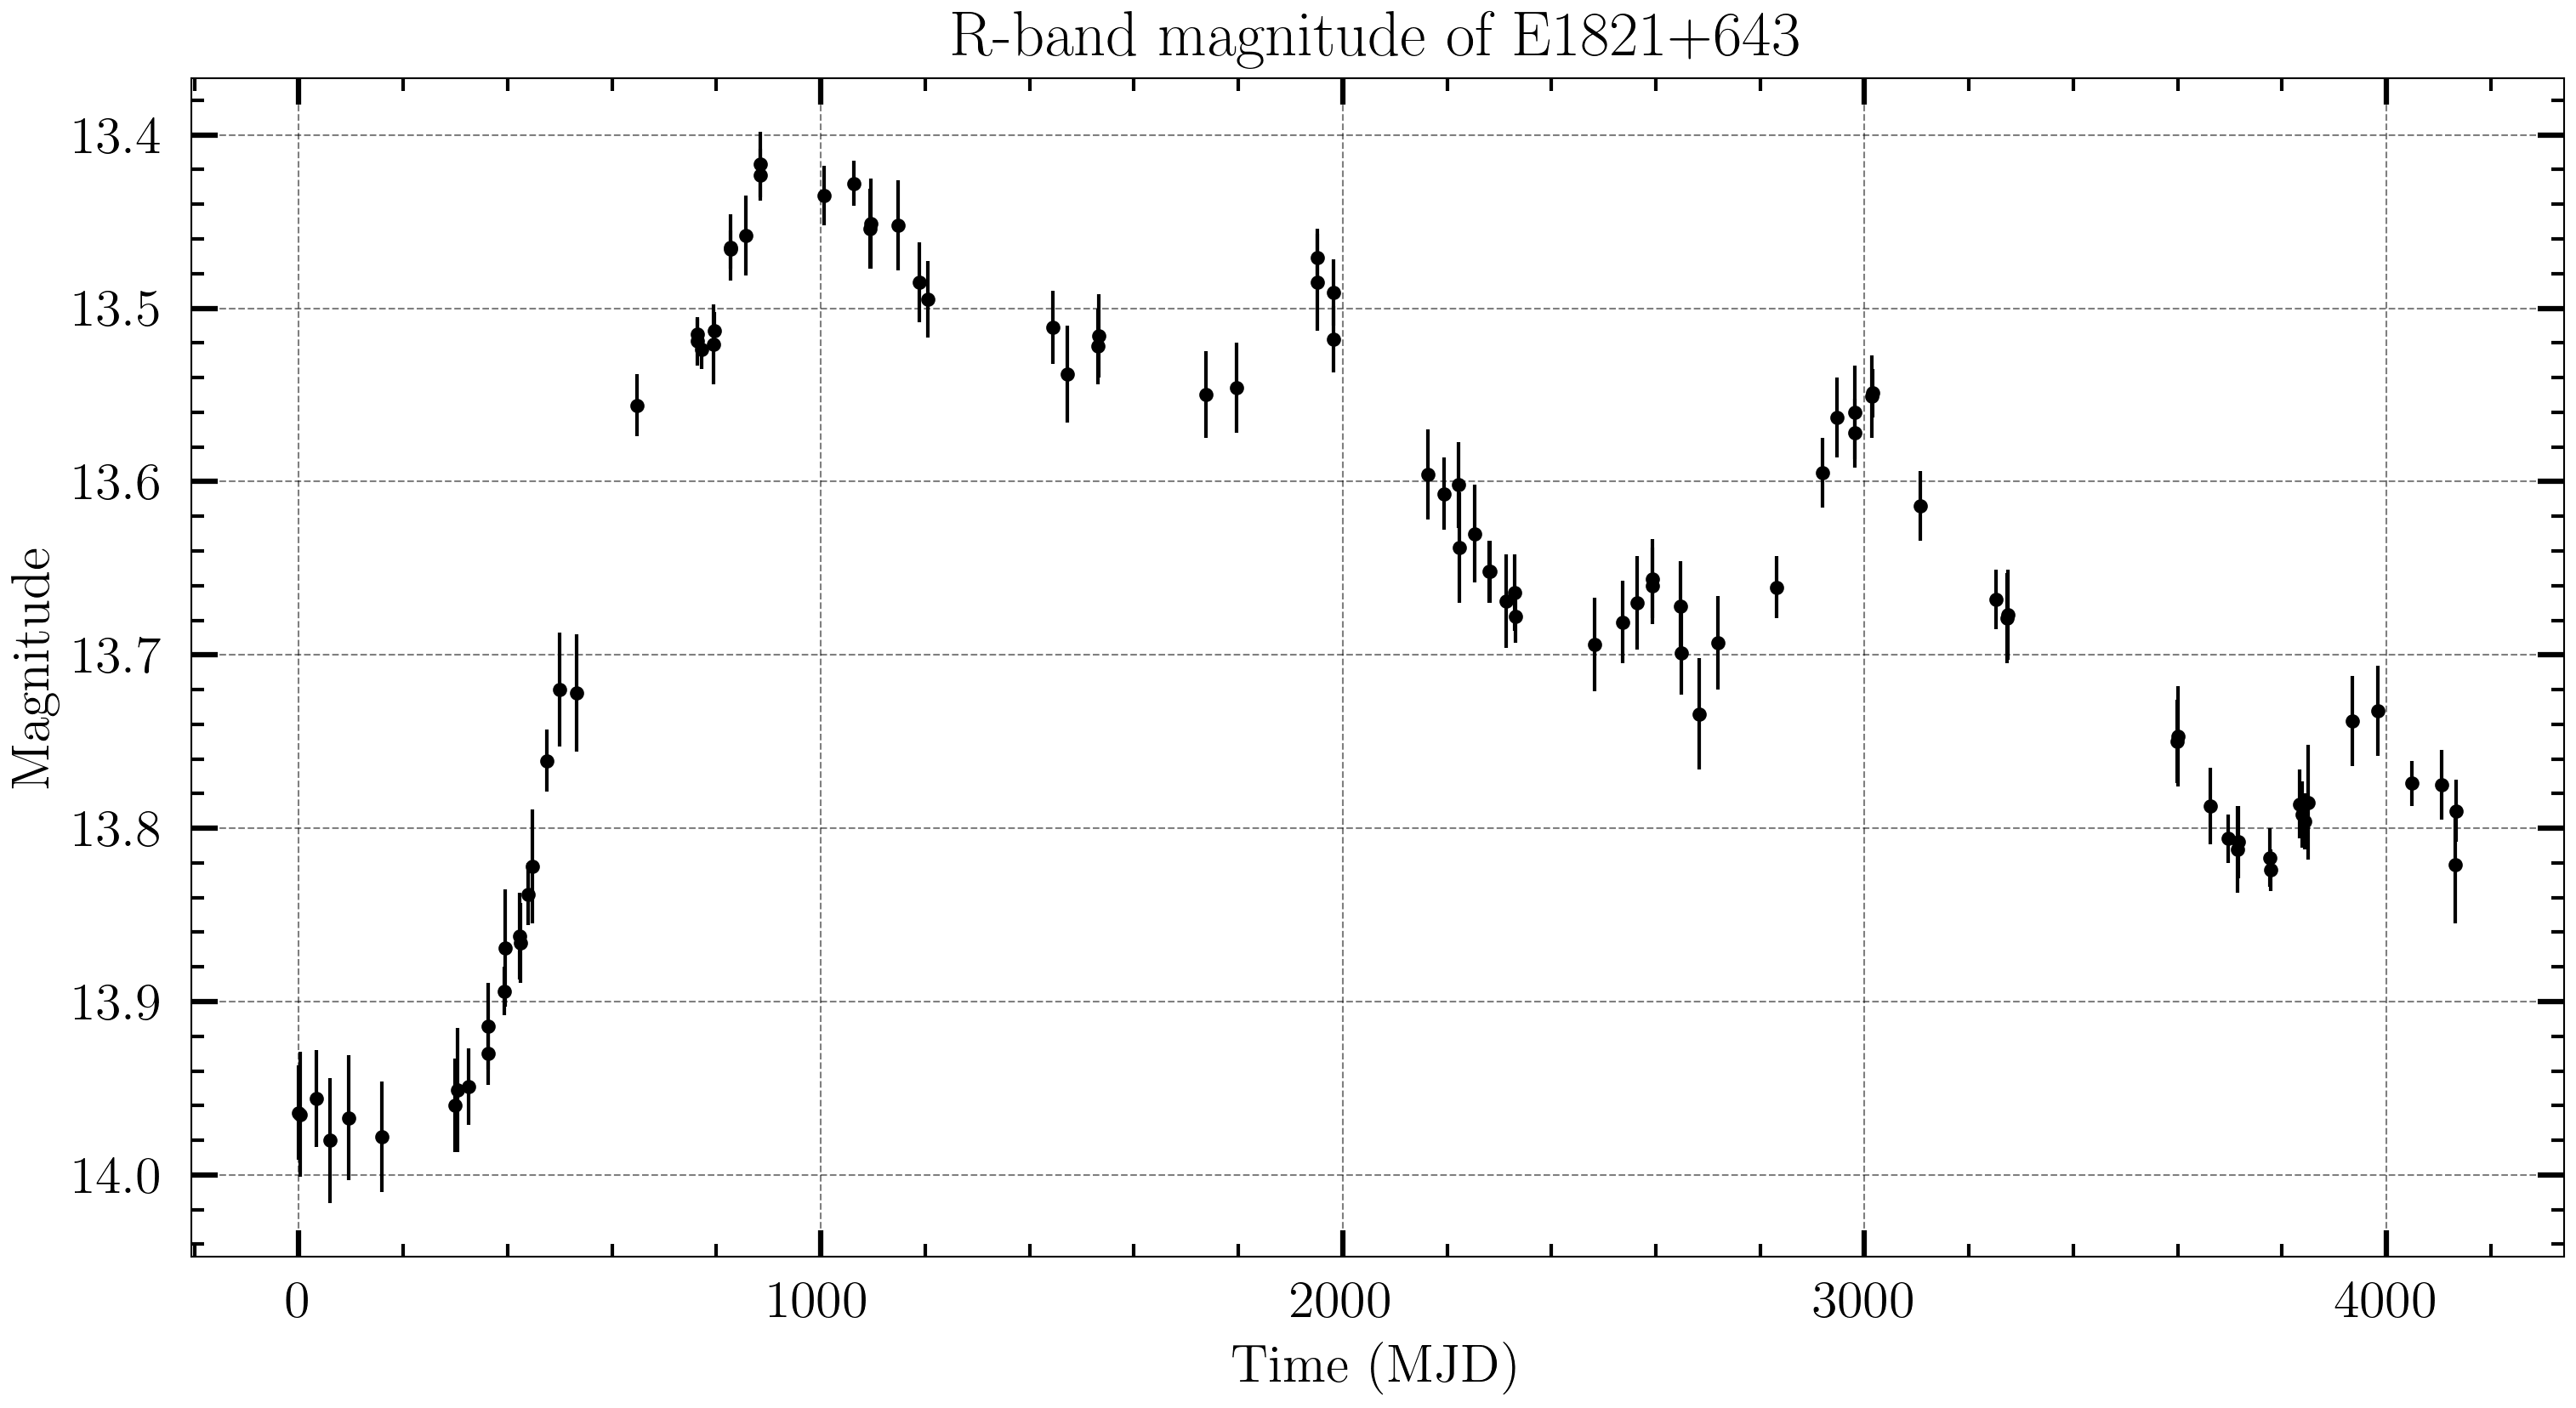

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.errorbar(E1821.JD.values - E1821.JD.values.min(), E1821.Rmag.values, yerr=E1821.e_Rmag.values, fmt='k.')
plt.gca().invert_yaxis()
plt.xlabel(r'Time (MJD)')
plt.ylabel(r'Magnitude')
plt.title(r'R-band magnitude of E1821+643')

## Testing EzTao and Celerite

We jump to creating Gaussian Process (GP) regression models for the R-band time series. In this case, we use *EzTao* and *celerite* GPs, both of which models the time series based on the Continuous-time Auto-regressive Moving Average (CARMA) model. 

For *EzTao*, we use the Damped Harmonic Oscillator kernel based on the stochastic differential equation

\begin{align}
	d^2x + a_1 dx + a_2 x = b_0 \epsilon(t) + b_1 d(\epsilon(t))
\end{align}

where we initialize the hyperparameters (in order): $a_1,~a_2,~b_0,~b_1$.

For *celerite*, we use the Simple Harmonic Oscillator kernel

\begin{align}
    k_{SHO}(\tau, S_0, Q, \omega_0) = S_0 \omega_0 Q \exp(-\omega_0 \tau/2Q) \left[\cos(\eta \omega_0 \tau) + \dfrac{1}{2\eta Q} \sin(\eta \omega_0 \tau)\right]
\end{align}

where we initialze the hyperparameters (in order): $S_0,~Q,~\omega_0$.

We then add a Damped Random Walk (DRW, aka the Ornstein-Uhlenbeck process) kernel to complete the GP regression model. This is defined by the equation 

\begin{align}
	k_{DRW}(A, C) = A \exp(-C\tau)
\end{align}


Since *EzTao* is based on *celerite*, we can treat the whole process as a *celerite* model.

Do note that this notebook should be run in parallel, depending on which GP you are running (i.e. `celerite.GP(kernel=dho_kernel+drw_kernel)` or `celerite.GP(kernel=cel_kern+drw_kernel)`). It might be bad habit, so I guess it's better to make a separate `gp` variable for each model.

In [9]:
E1821_days = E1821.JD.values - E1821.JD.values.min()

# Define the celerite model (replace this with your specific model)
dho_init_params = [1.0, 1.0, 1.0, 1.0]
dho_kernel = DHO_term(*dho_init_params) # log_a1, log a2, log b0, log b2
cel_kern = terms.SHOTerm(log_S0=0.0, log_Q=0.0, log_omega0=-2.0)
# cel_kern2 = terms
drw_init_params = [1.0, 1.0]
drw_kernel = DRW_term(*drw_init_params)

gp = celerite.GP(kernel=dho_kernel+drw_kernel)
gp.compute(E1821_days, yerr=E1821.e_Rmag.values)

We can also show the covariance matrix so that we can have an idea if it is solvable by Cholesky decomposition (though, in practice this is difficult to assess visually).

In [ ]:
sample = np.linspace(0,100,1000)

plt.figure(figsize=(12,12))
plt.imshow(gp.get_matrix(sample), cmap='gray')

To give an idea to our Nested sampling, we optimize the GP model using *scipy*, and get the point estimates which we can use as the peak location of our Gaussian priors. 

In [10]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
# bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(E1821.Rmag.values, gp))
gp.set_parameter_vector(r.x)
print(r)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 10.478219324369164
        x: [ 2.197e+00  6.323e-01  9.081e-01 -8.472e-01  6.886e+00
             2.629e+01]
      nit: 8
      jac: [-5.233e+01 -3.246e+01  7.012e+01  5.070e+00 -4.420e-01
             0.000e+00]
     nfev: 84
     njev: 12
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


We can also plot the GP mean and its $2\sigma$ uncertainty region together with the data after we have optimized the GP.

Text(0.5, 1.0, 'R-band magnitude of E1821+643')

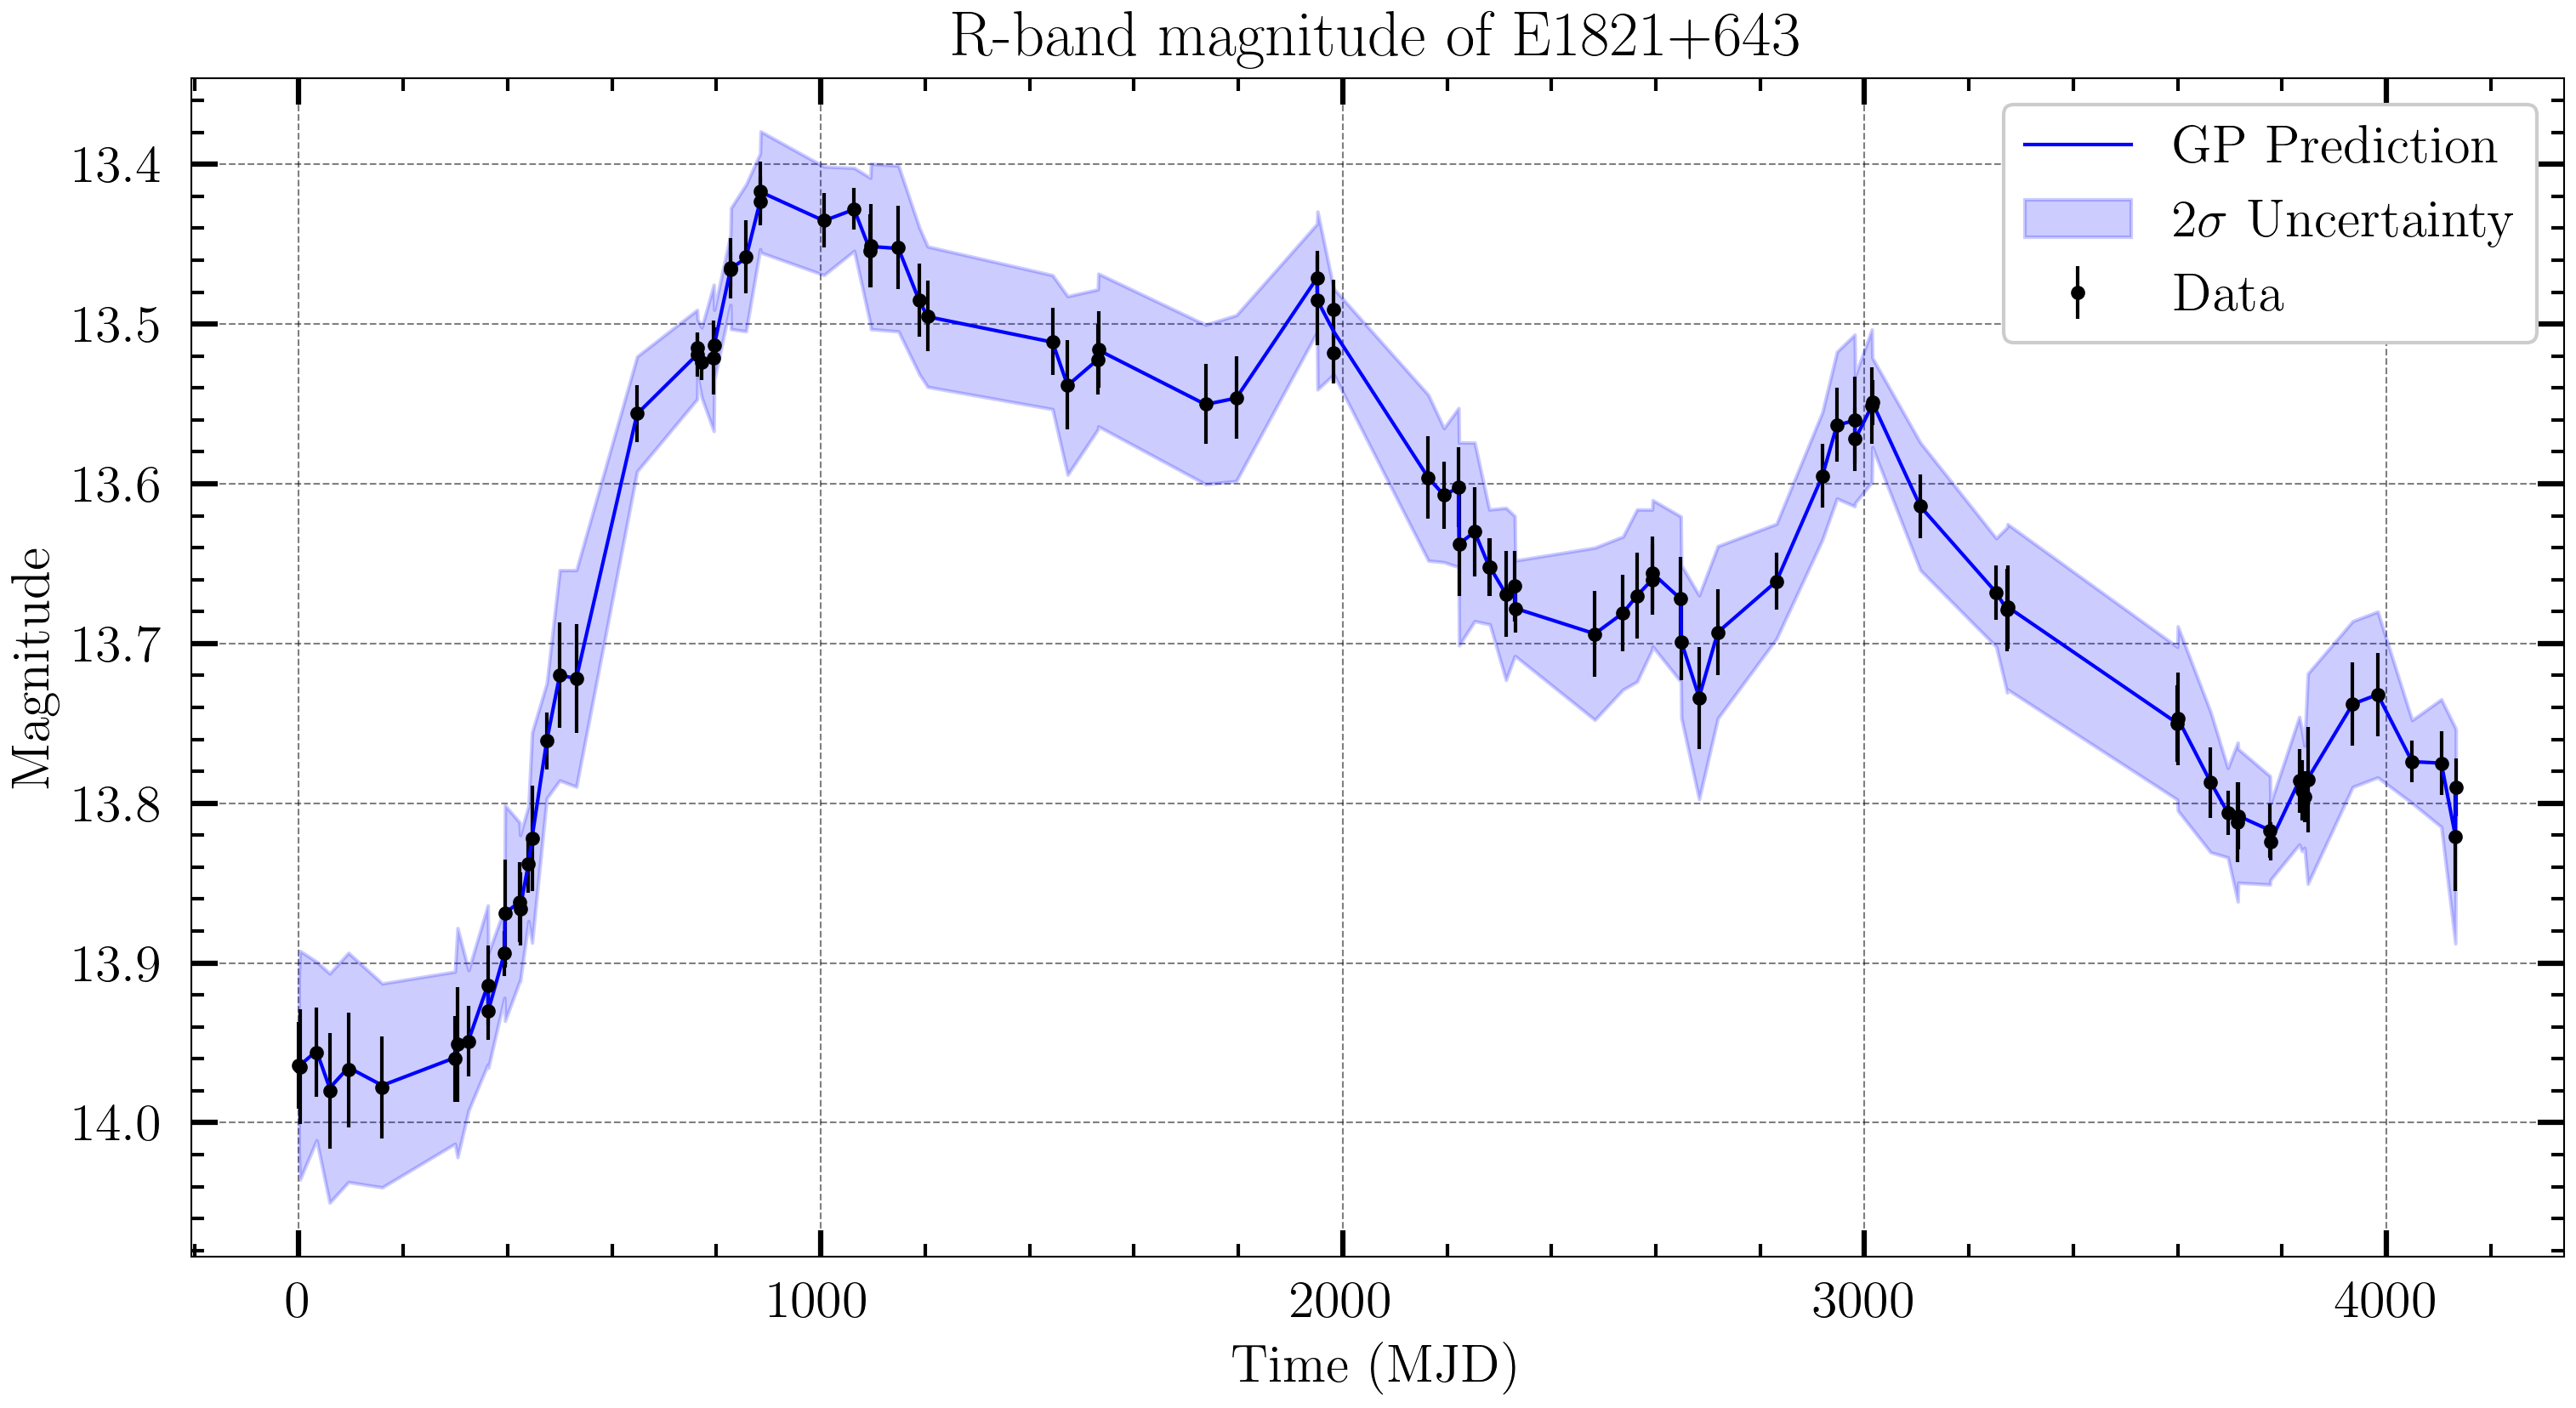

In [11]:
pred_mean, pred_var = gp.predict(E1821.Rmag.values, return_var=True)

plt.figure(figsize=(12,6))
# Plot the data
plt.errorbar(E1821_days, E1821.Rmag.values, yerr=E1821.e_Rmag.values, fmt='.k', capsize=0, label='Data')

# Plot the GP prediction
plt.plot(E1821_days, pred_mean, label='GP Prediction', color='blue')

# Plot the original tick-tock signal
# plt.plot(real_times, trial, 'r--', label='Original function')

# Shade the uncertainty region
plt.fill_between(E1821_days, pred_mean - 2*np.sqrt(pred_var), pred_mean + 2*np.sqrt(pred_var), color='blue', alpha=0.2, label=r'$2\sigma$ Uncertainty')

plt.gca().invert_yaxis()
plt.legend(loc='best')
plt.xlabel(r'Time (MJD)')
plt.ylabel(r'Magnitude')
plt.title(r'R-band magnitude of E1821+643')

## Nested Sampling via Dynesty

In [12]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_a1', 2.196570597110334),
             ('kernel:terms[0]:log_a2', 0.6323370391763109),
             ('kernel:terms[0]:log_b0', 0.9081209737277838),
             ('kernel:terms[0]:log_b1', -0.8472486413092952),
             ('kernel:terms[1]:log_amp', 6.88644898597615),
             ('kernel:terms[1]:log_tau', 26.293268210059964)])

In constructing the *dynesty* sampler, we need to take into account the arrangement of the parameters above. This should be the same arrangemet in constructing the prior transform which will be used later on to calculate the (log) likelihood. Notice we used `scipy.stats.norm.ppf` to create the priors. This function returns the inverse CDF of the Gaussian distribution, i.e. the value at the bell-shaped curve centered at the specified location with a standard deviation of 1.

In [13]:
######################### EzTao ############################
from scipy.stats import norm

# Define the log-likelihood function
def log_likelihood(params, y, gp):
    gp.kernel.set_parameter_vector(params)

    # Compute the log likelihood
    return gp.log_likelihood(y)

# Define the prior transform
def ptform(u):
    """
    Transforms from u~[0,1) to parameter space of interest
    """
    uloga1, uloga2, ulogb0, ulogb1, ulogamp, ulogtau = u
    
    loga1 = norm.ppf(uloga1, loc=2.19)
    loga2 = norm.ppf(uloga2, loc=0.63)
    logb0 = norm.ppf(ulogb0, loc=0.9)
    logb1 = norm.ppf(ulogb1, loc=-0.85)
    logamp = norm.ppf(ulogamp, loc=6.88)
    logtau = norm.ppf(ulogtau, loc=26.3)

    
    return loga1, loga2, logb0, logb1, logamp, logtau

In [ ]:
######################### celerite ############################
from scipy.stats import norm

# Define the log-likelihood function
def log_likelihood(params, y, gp):
    gp.kernel.set_parameter_vector(params)

    # Compute the log likelihood
    return gp.log_likelihood(y)

# Define the prior transform
def ptform(u):
    """
    Transforms from u~[0,1) to parameter space of interest
    """
    ulogS0, ulogQ, ulogomega0, ulogamp, ulogtau = u
#     logS0 = (ulogS0 - 2) # log s0 = [-5, 5]
#     logQ = (ulogQ - 2)
#     logomega0 = 5*(ulogomega0 - 1.5)
#     logamp = 5*(ulogamp*2 + 1)
#     logtau = 10*(ulogtau*2 + 2)
    logS0 = norm.ppf(ulogS0, loc=-1.3)
    logQ = norm.ppf(ulogQ, loc=-1.3)
    logomega0 = norm.ppf(ulogomega0, loc=-4.15)
    logamp = norm.ppf(ulogamp, loc=8.02)
    logtau = norm.ppf(ulogtau, loc=32.0)

    
    return logS0, logQ, logomega0, logamp, logtau

We can then start the Nested sampling procedure as normal. For our purposes, calculating the evidence is enough from the results such that we don't necessarily need the posterior samples from MAP estimation.

In [ ]:
################# Celerite + DRW ######################
# sampler for evidence estimation
sampler_cel = dynesty.DynamicNestedSampler(log_likelihood, ptform, ndim=5,
                                bound='multi', sample='rslice',
                               rstate=rstate, logl_args=(E1821.Rmag.values, gp))
sampler_cel.run_nested()
res_cel = sampler_cel.results

In [ ]:
# sampler for MAP estimation
sampler_cel.reset()
sampler_cel.run_nested(nlive_init=1000, nlive_batch=500, wt_kwargs={'pfrac': 1.0}, stop_kwargs={'pfrac': 1.0})
respos_cel = sampler_cel.results

In [14]:
###################### EzTao + DRW ###########################
# sampler for evidence estimation
sampler_ezt = dynesty.DynamicNestedSampler(log_likelihood, ptform, ndim=6,
                                bound='multi', sample='rslice',
                               rstate=rstate, logl_args=(E1821.Rmag.values, gp))
sampler_ezt.run_nested()
res_ezt = sampler_ezt.results

0it [00:00, ?it/s] /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/sampler.py:746: RuntimeWarning:underflow encountered in logaddexp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1350: RuntimeWarning:underflow encountered in logaddexp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1351: RuntimeWarning:underflow encountered in logaddexp
9623it [06:20, 596.50it/s, batch: 0 | bound: 59 | nc: 1 | ncall: 522610 | eff(%):  1.840 | loglstar:   -inf < 185.046 <    inf | logz: 171.374 +/-  0.148 | dlogz:  0.005 >  0.010]   /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1311: RuntimeWarning:underflow encountered in logaddexp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1326: RuntimeWarning:underflow encountered in exp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:897: RuntimeWarning:underflow encountered in square
9896it [06:41, 20.95it/s, batch: 1 | bound

In [15]:
########################## EzTao + DRW #######################
# sampler for MAP estimation
sampler_ezt.reset()
sampler_ezt.run_nested(nlive_init=1000, nlive_batch=500, wt_kwargs={'pfrac': 1.0}, stop_kwargs={'pfrac': 1.0})
respos_ezt = sampler_ezt.results

0it [00:00, ?it/s] /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/sampler.py:746: RuntimeWarning:underflow encountered in logaddexp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1350: RuntimeWarning:underflow encountered in logaddexp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1351: RuntimeWarning:underflow encountered in logaddexp
21754it [19:14, 1425.60it/s, batch: 0 | bound: 78 | nc: 1 | ncall: 1239698 | eff(%):  1.755 | loglstar:   -inf < 186.565 <    inf | logz: 171.439 +/-  0.105 | dlogz:  0.002 >  0.010] /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1311: RuntimeWarning:underflow encountered in logaddexp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:1326: RuntimeWarning:underflow encountered in exp
 /home/mibrivera/anaconda3/lib/python3.9/site-packages/dynesty/utils.py:897: RuntimeWarning:underflow encountered in square
21932it [19:48, 17.37it/s, batch: 1 | bou

## Plotting

In [ ]:
from dynesty import plotting as dyplot

dyplot.runplot(res_ezt)
plt.tight_layout()

In [ ]:
########################### EzTao #############################
labels = [r'$\ln a_1$', r'$\ln a_2$', r'$\ln b_0$', r'$\ln b_1$', r'$\ln A$', r'$\ln \tau$']
# truths = [logs0, logQ, logomega0]
fig, axes = dyplot.traceplot(res_ezt, labels=labels,
                             fig=plt.subplots(6, 2, figsize=(16, 25)))
fig.tight_layout()

In [ ]:
########################### celerite ##########################
labels = [r'$\ln S_0$', r'$\ln Q$', r'$\ln \omega_0$', r'$\ln A$', r'$\ln \tau$']
# truths = [logs0, logQ, logomega0]
fig, axes = dyplot.traceplot(res_cel, labels=labels,
                             fig=plt.subplots(5, 2, figsize=(16, 25)))
fig.tight_layout()

In [ ]:
fig, axes = dyplot.cornerplot(respos_ezt, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(6,6, figsize=(35, 35)))

In [ ]:
fig, axes = dyplot.cornerplot(respos_cel, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(5,5, figsize=(35, 35)))

In [ ]:
gp.log_likelihood(E1821.Rmag.values)

In [19]:
res_ezt.logzerr

array([8.95409847e-113, 2.51914374e-111, 1.00678008e-102, ...,
       9.07122756e-002, 9.13797667e-002, 9.25717865e-002])

In [ ]:
best_fit_params = respos_cel.samples[np.argmax(respos_cel.logl)]
max_loglike = np.max(respos_cel.logl)
print(best_fit_params, max_loglike)
# print("Optimized Parameters:", respos.samples[-1])

In [ ]:
gp.set_parameter_vector(best_fit_params)

x = np.linspace(E1821_days.min(), E1821_days.max(),5000)

opt_mean, opt_var = gp.predict(E1821.Rmag.values, return_var=True)

plt.figure(figsize=(12,6))
# Plot the data
plt.errorbar(E1821_days, E1821.Rmag.values, yerr=E1821.e_Rmag.values, fmt='.k', capsize=0, label='Data')

# Plot the GP prediction
plt.plot(E1821_days, opt_mean, label='GP Prediction', color='blue')

# Plot the original tick-tock signal
# plt.plot(real_times, trial, 'r--', label='Original function')

# Shade the uncertainty region
plt.fill_between(E1821_days, opt_mean - 2*np.sqrt(opt_var), opt_mean + 2*np.sqrt(opt_var), color='blue', alpha=0.2, label=r'$2\sigma$ Uncertainty')

plt.gca().invert_yaxis()
plt.legend(loc='best')
plt.xlabel(r'Time (MJD)')
plt.ylabel(r'Magnitude')
plt.title(r'R-band magnitude of E1821+643 with optimized DHO + DRW GP')

## Bayes Factor calculation

We can then get the results of both the (log) evidence and their errors from both models. (Of course, comment out the other runs)

In [16]:
# Save the log Z
np.savetxt('LogZ_DRW+DHO_Rband.txt', res_ezt.logz, fmt='%.5e')
# np.savetxt('LogZ_DRW+SHO_Rband.txt', res_cel.logz, fmt='%.5e')

# Save the log Z errors
np.savetxt('LogZerr_DRW+DHO_Rband.txt', res_ezt.logzerr, fmt='%.5e')
# np.savetxt('LogZerr_DRW+SHO_Rband.txt', res_cel.logzerr, fmt='%.5e')

In [17]:
logZ_EzTao = np.loadtxt('LogZ_DRW+DHO_Rband.txt')
logZ_cel = np.loadtxt('LogZ_DRW+SHO_Rband.txt')

logZerr_EzTao = np.loadtxt('LogZerr_DRW+DHO_Rband.txt')
logZerr_cel = np.loadtxt('LogZerr_DRW+SHO_Rband.txt')

print(logZ_EzTao[-1], logZ_cel[-1], logZerr_EzTao[-1], logZerr_cel[-1])

171.43 185.495 0.0925718 0.0926199


Since the log evidence is calculated cumulatively, we can use the last element in the array to solve the (log) Bayes factor, given by

\begin{align}
    \ln B_{12} &= \ln Z_1 - \ln Z_2 \\
    \sigma_{\ln B_{12}} &= \sqrt{\sigma_{Z_1}^2 + \sigma_{Z_2}^2}
\end{align}

In [18]:
def compute_log_bayes_factor(logz1, logz2, logzerr1, logzerr2):
    """
    Assuming the calculated log Z and errors are cumulative (as given in dynesty run)
    """
    log_bayes_factor = logz1[-1] - logz2[-1]
        
    error_log_bayes_factor = np.sqrt(logzerr1[-1]**2 + logzerr2[-1]**2)
    
    return log_bayes_factor, error_log_bayes_factor

logbayes_factor, logbf_error = compute_log_bayes_factor(logZ_EzTao, logZ_cel, logZerr_EzTao, logZerr_cel)
# bf_error = compute_bayes_factor_error(logl_EzTao, logl_cel)

print("Log Bayes Factor:", logbayes_factor)
print("Log Bayes Factor Error:", logbf_error)


Log Bayes Factor: -14.064999999999998
Log Bayes Factor Error: 0.13095031130642645


### Result: celerite is (strongly) preferred! (log scale so around 1e-14)